# Problem Description

In [ ]:
#Importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   #importing matplotlib will help us to plot figures
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from time import time
from sklearn.metrics import auc

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
#warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import RandomizedSearchCV

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings

In [ ]:
#Importing the dataset
news_df = pd.read_csv("./fake_job_postings.csv")
news_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
#Checking the shape of the dataset
news_df.shape

(17880, 18)

In [ ]:
#Viewing the info of the data frame to see what type of data each column has
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
df = news_df.set_index('job_id')

In [ ]:
#Checking for missing values
df.isnull().sum()
round(100*(df.isnull().sum()/len(df.index)),2)

title                   0.00
location                1.94
department             64.58
salary_range           83.96
company_profile        18.50
description             0.01
requirements           15.07
benefits               40.32
telecommuting           0.00
has_company_logo        0.00
has_questions           0.00
employment_type        19.41
required_experience    39.43
required_education     45.33
industry               27.42
function               36.10
fraudulent              0.00
dtype: float64

### Dealing with Missing values 

In [ ]:
salary_range = df['salary_range']
salary_range

job_id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
        ... 
17876    NaN
17877    NaN
17878    NaN
17879    NaN
17880    NaN
Name: salary_range, Length: 17880, dtype: object

In [ ]:
#What if we drop these NAN values?
salary_range.dropna()

job_id
7          20000-28000
11       100000-120000
16       120000-150000
24       100000-120000
32         50000-65000
             ...      
17845              0-0
17850     80000-100000
17866      18000-20000
17868      18000-19000
17875     80000-100000
Name: salary_range, Length: 2868, dtype: object

In [ ]:
#Redefining salary
df['min_salary'] = 0
df['max_salary'] = 0

df['salary_range'] = df['salary_range'].str.split('-')

In [ ]:
for i in range(len(df)):
    try:
        value = df['salary_range'].iloc[i]
        if type(value) is list:
            df['min_salary'].iloc[i] = int(value[0])
            df['max_salary'].iloc[i] = int(value[1])
            df['salary_range'].iloc[i] = int(value[1]) - int(value[0])
        else:
            df['salary_range'].iloc[i] = 0
            
    except ValueError:
        df['salary_range'].iloc[i] = 0
    except IndexError:
        df['salary_range'].iloc[i] = 0
df['salary_range'] = df['salary_range'].astype(str).astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df['salary_range'].dtype

dtype('int64')

In [ ]:
df[df['salary_range']!=0].head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary
job_id,,,,,,,,,,,,,,,,,,,
7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,8000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0,20000,28000
11,ASP.net Developer Job opportunity at United St...,"US, NJ, Jersey City",NaN,20000,NaN,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Benefits - FullBonus Eligible - YesInterview T...,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0,100000,120000
16,VP of Sales - Vault Dragon,"SG, 01, Singapore",Sales,30000,Jungle Ventures is the leading Singapore based...,About Vault Dragon Vault Dragon is Dropbox for...,Key Superpowers3-5 years of high-pressure sale...,"Basic: SGD 120,000Equity negotiable for a rock...",0,1,1,Full-time,Executive,Bachelor's Degree,Facilities Services,Sales,0,120000,150000
24,"Vice President, Sales and Sponsorship (Busines...","US, CA, Carlsbad",Businessfriend.com,20000,"WDM Group is an innovative, forward thinking d...",#URL_eda2500ddcedb60957fcd7f5b164e092966f8c4e8...,"Job Requirements:A reputation as a ""go-getter""...",Businessfriend will offer a competitive six fi...,0,1,0,Full-time,Executive,Unspecified,Internet,Sales,0,100000,120000
32,Software Applications Specialist,"US, KS,",NaN,15000,NaN,"Day to Day-Install, upgrade and configure web-...",Must Have's3+ years of experience with web-bas...,"Medical, Dental, Vision, Life, Disability, Pre...",0,1,0,Full-time,Associate,Unspecified,Computer Software,Engineering,0,50000,65000


In [ ]:
df.drop(['min_salary', 'max_salary'], axis=1, inplace=True)

In [ ]:
df["required_experience"] = df["required_experience"].fillna(value='Not Applicable')
df["required_experience"].value_counts(dropna=False)

Not Applicable      8166
Mid-Senior level    3809
Entry level         2697
Associate           2297
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

In [ ]:
df["required_education"].value_counts(dropna=False)

NaN                                  8105
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

In [ ]:
df["required_education"] = df["required_education"].fillna(value='Unspecified')
df["required_education"].value_counts(dropna=False)
df.replace('Some College Coursework Completed', 'Some College Coursework', inplace=True)
df.replace('Some High School Coursework', 'Some HS Coursework', inplace=True)

In [ ]:
df["employment_type"] = df["employment_type"].fillna(value='Other')
df["employment_type"].value_counts(dropna=False)

Full-time    11620
Other         3698
Contract      1524
Part-time      797
Temporary      241
Name: employment_type, dtype: int64

In [ ]:
df["function"] = df["function"].fillna(value='Other')
df["function"].value_counts(dropna=False)

Other                     6780
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Education                  325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Art/Creative               132
Writing/Editing            132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training                    38
Supply C

In [ ]:
df = df.drop(['department', 'industry'], axis=1)

Now its time to fill in the null values for the columns that contain substantial textual data.

Let's fill the nulls that exsist in title, location, company_profile, description, requirements and benefits with empty strings.

In [ ]:
df['location'] = df['location'].fillna("")
df['company_profile'] = df['company_profile'].fillna("")
df['description'] = df['description'].fillna("")
df['requirements'] = df['requirements'].fillna("")
df['benefits'] = df['benefits'].fillna("")

### Textual data


In [ ]:
#combining all the text columns into one text column

df['text'] = df[['title', 'company_profile', 'description', 
                                 'requirements', 'benefits']].apply(' - '.join, axis=1)
df = df.drop(['title', 'location', 'company_profile', 'description', 
                              'requirements', 'benefits'], axis=1)

In [ ]:
df.head()

,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,function,fraudulent,text
job_id,,,,,,,,,,
1,0,0,1,0,Other,Internship,Unspecified,Marketing,0,"Marketing Intern - We're Food52, and we've cre..."
2,0,0,1,0,Full-time,Not Applicable,Unspecified,Customer Service,0,Customer Service - Cloud Video Production - 90...
3,0,0,1,0,Other,Not Applicable,Unspecified,Other,0,Commissioning Machinery Assistant (CMA) - Valo...
4,0,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Sales,0,Account Executive - Washington DC - Our passio...
5,0,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Health Care Provider,0,Bill Review Manager - SpotSource Solutions LLC...


## Cleaning Text Data

### Removing Stopwords, Punctation and Special Characters

In [ ]:
nltk.download('stopwords')

df['text'] = df['text'].str.lower()
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['text'] = df['text'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '')
df['text'] = df['text'].str.replace(r'[\'-]', '')
df['text'] = df['text'].str.replace(r'[\'\",()*&^%$#@!~`+=|/<>?{}\[\]\/\\:;\_]]', ' ') # remove punctuation
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('url')]))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split(' ') if len(word)<25]))
df['text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))
df['text'] = df['text'].str.replace(r'[0-9]', '') # get rid of numbers
df['text'] = df['text'].str.replace(r'[^a-z]', ' ') # get rid of any non english characters

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Applying Lemmatizer

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
df['text'] = df['text'].apply(lemmatize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['text'] = [' '.join(map(str, l)) for l in df['text']]

In [ ]:
df.head(3)

,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,function,fraudulent,text
job_id,,,,,,,,,,
1,0,0,1,0,Other,Internship,Unspecified,Marketing,0,marketing intern were food weve created ground...
2,0,0,1,0,Full-time,Not Applicable,Unspecified,Customer Service,0,customer service cloud video production second...
3,0,0,1,0,Other,Not Applicable,Unspecified,Other,0,commissioning machinery assistant cma valor se...


In [ ]:
df.describe()

,salary_range,telecommuting,has_company_logo,has_questions,fraudulent
count,1.788000e+04,17880.000000,17880.000000,17880.000000,17880.000000
mean,4.719018e+04,0.042897,0.795302,0.491723,0.048434
std,3.744941e+06,0.202631,0.403492,0.499945,0.214688
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,1.000000,0.000000,0.000000
50%,0.000000e+00,0.000000,1.000000,0.000000,0.000000
75%,0.000000e+00,0.000000,1.000000,1.000000,0.000000
max,4.000000e+08,1.000000,1.000000,1.000000,1.000000


Seems like we either have some extreme outliers in salary_range, min_salary and max_salary, and/or majority of the values are 0. Let's take a peek at what the non-zero/outlying salaries look like.

In [ ]:
non_zero_salary = df[df['salary_range']!=0]

In [ ]:
# find outliers using IQR
Q1 = np.percentile(non_zero_salary['salary_range'] , 25) 
Q3 = np.percentile(non_zero_salary['salary_range'] , 75)
IQR = Q3 - Q1
low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR

In [ ]:
outliers = []
for salary in non_zero_salary['salary_range'] :
    if ((salary > up_lim) or (salary < low_lim)):
         outliers.append(salary)

In [ ]:
non_zero_salary = non_zero_salary[~non_zero_salary['salary_range'].isin(outliers)]

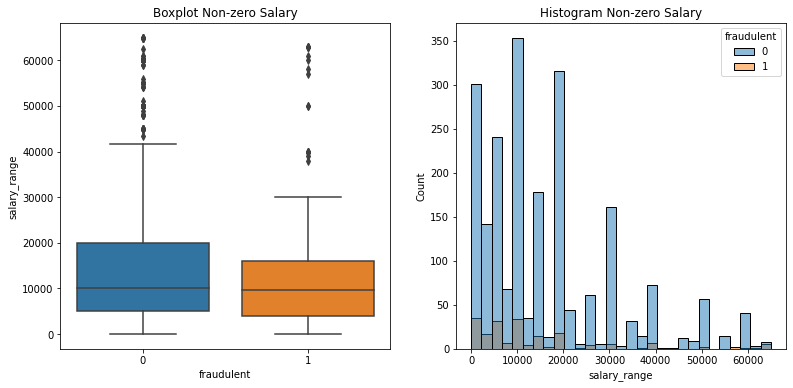

In [84]:
box_title = 'Boxplot Non-zero Salary'
hist_title = 'Histogram Non-zero Salary'
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

sns.boxplot(x='fraudulent', y='salary_range', data=non_zero_salary, ax=axes[0]).set_title(box_title)
sns.histplot(hue='fraudulent', x='salary_range', data=non_zero_salary, ax=axes[1]).set_title(hist_title)
plt.show()

From the plots, it looks like the salaries are pretty low and right skewed, regardless of fraudulence or not.

Time to take another look at some of the other features.

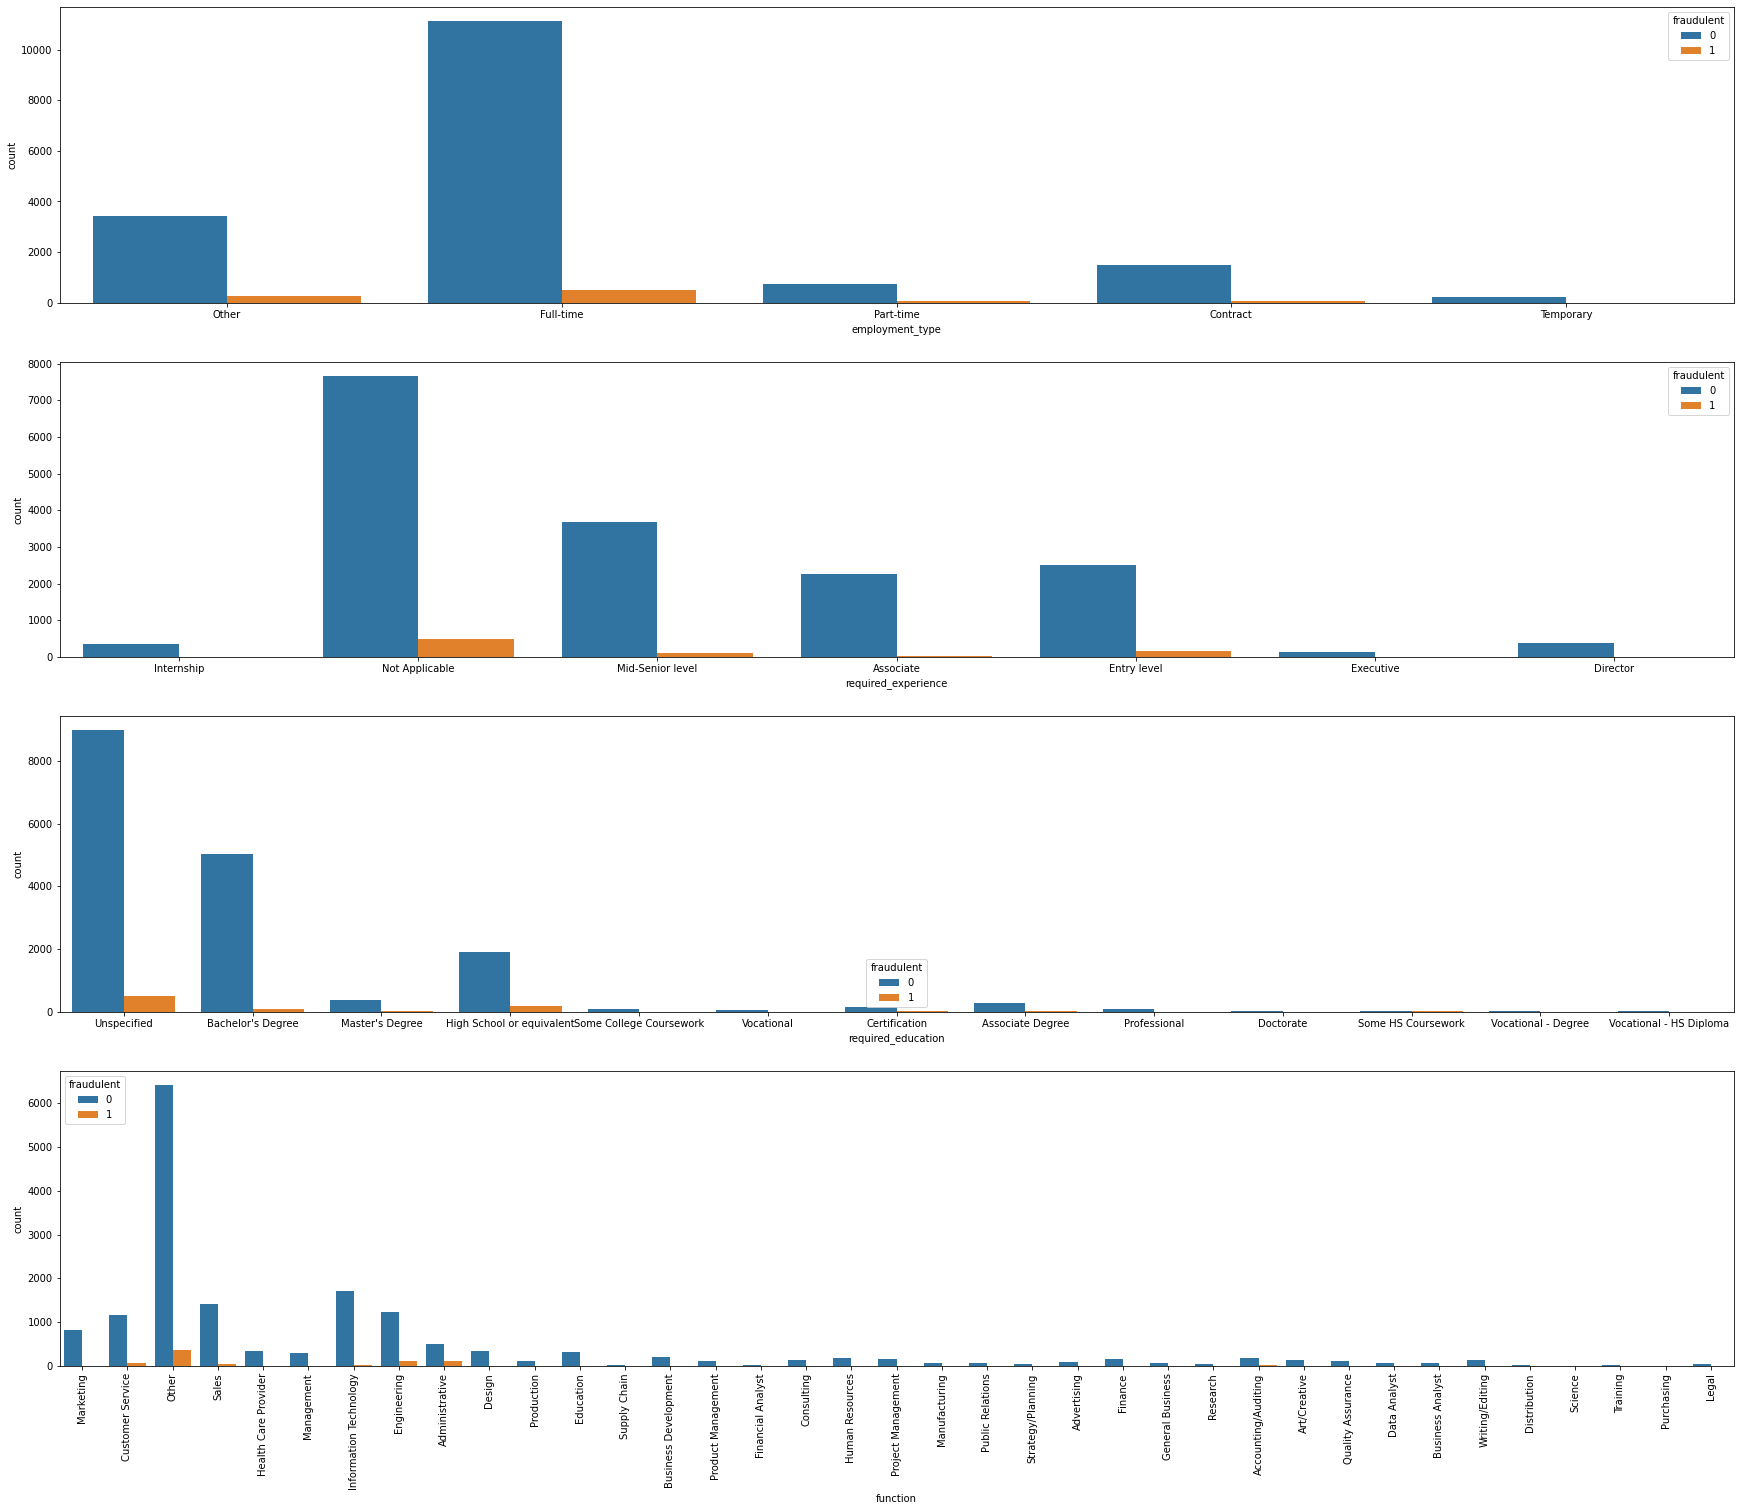

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(30, 25))
plt.xticks(rotation=90)
sns.countplot(x="employment_type", hue="fraudulent", data=df, ax=axes[0])
sns.countplot(x="required_experience", hue="fraudulent", data=df, ax=axes[1])
sns.countplot(x="required_education", hue="fraudulent", data=df, ax=axes[2])
sns.countplot(x="function", hue="fraudulent", data=df, ax=axes[3])
plt.show()

The distributions of real and fake jobs are roughly the same for these features. Mostly full time, unspecified or bachelors education, or an Other job fuction.

Let's look at some the binary features.

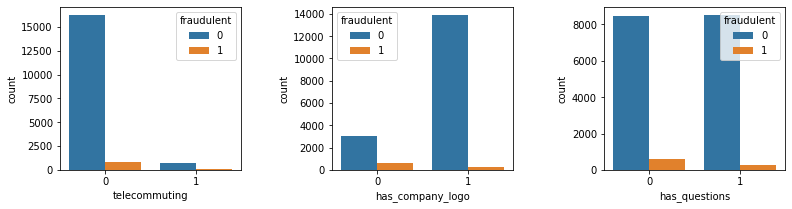

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(13, 3))
sns.countplot(x="telecommuting", hue="fraudulent", data=df, ax=axes[0])
sns.countplot(x="has_company_logo", hue="fraudulent", data=df, ax=axes[1])
sns.countplot(x="has_questions", hue="fraudulent", data=df, ax=axes[2])
plt.subplots_adjust(wspace=0.5)
plt.show()

The 'telecommuting' feature is highly imbalanced and so it's safe to drop.  

### Encoding

There are several features that need to be encoded, let's look at them 

In [ ]:
for col in df[['employment_type', 'required_experience', 'required_education', 'function']].columns:
    print(col + ":", set(df[col]), "\n")

employment_type: {'Full-time', 'Other', 'Contract', 'Temporary', 'Part-time'} 

required_experience: {'Executive', 'Director', 'Internship', 'Entry level', 'Mid-Senior level', 'Not Applicable', 'Associate'} 

required_education: {'Unspecified', 'Some HS Coursework', 'Vocational - Degree', 'Some College Coursework', 'Doctorate', 'Vocational - HS Diploma', "Bachelor's Degree", 'Vocational', 'High School or equivalent', 'Professional', 'Certification', 'Associate Degree', "Master's Degree"} 

function: {'Research', 'Administrative', 'Business Development', 'Finance', 'Customer Service', 'General Business', 'Science', 'Writing/Editing', 'Human Resources', 'Marketing', 'Distribution', 'Information Technology', 'Legal', 'Accounting/Auditing', 'Product Management', 'Project Management', 'Sales', 'Design', 'Business Analyst', 'Art/Creative', 'Management', 'Consulting', 'Health Care Provider', 'Education', 'Financial Analyst', 'Supply Chain', 'Public Relations', 'Purchasing', 'Manufacturing', '

### Label Encoder

'employement_type' and 'function' require a label encoder

In [ ]:
le = LabelEncoder()

le.fit(df['employment_type'])
df['employment_type'] = le.transform(df['employment_type'])

In [ ]:
le.fit(df['function'])
df['function'] = le.transform(df['function'])

In [ ]:
set(df['required_experience'])

{'Associate',
 'Director',
 'Entry level',
 'Executive',
 'Internship',
 'Mid-Senior level',
 'Not Applicable'}

In [ ]:
oe = OrdinalEncoder()
oe.fit(df[['required_experience']])
df['required_experience'] = oe.transform(df[['required_experience']])

In [ ]:
set(df['required_education'])

{'Associate Degree',
 "Bachelor's Degree",
 'Certification',
 'Doctorate',
 'High School or equivalent',
 "Master's Degree",
 'Professional',
 'Some College Coursework',
 'Some HS Coursework',
 'Unspecified',
 'Vocational',
 'Vocational - Degree',
 'Vocational - HS Diploma'}

In [ ]:
oe = OrdinalEncoder()
oe.fit(df[['required_education']])
df['required_education'] = oe.transform(df[['required_education']])

In [ ]:
df.head()

,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,function,fraudulent,text
job_id,,,,,,,,,,
1,0,0,1,0,2,4.0,9.0,22,0,marketing intern were food weve created ground...
2,0,0,1,0,1,6.0,9.0,7,0,customer service cloud video production second...
3,0,0,1,0,2,6.0,9.0,23,0,commissioning machinery assistant cma valor se...
4,0,0,1,0,1,5.0,1.0,31,0,account executive washington dc passion improv...
5,0,0,1,1,1,5.0,1.0,16,0,bill review manager spotsource solution llc gl...


EDA is all done, but for training the model, until relationship between variables is verified, we will primarily need the 'text' column.  

In [ ]:
df2 = df.drop(['salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
          'required_experience', 'required_education', 'function'], axis=1)

## Text Processing

In [ ]:
vectorizer = TfidfVectorizer(max_features=8000)

vectorizer.fit(df2['text'])

TfidfVectorizer(max_features=8000)

In [ ]:
X = vectorizer.fit_transform(df2['text']).toarray()   # independent
y = df2['fraudulent']   # dependent

In [ ]:
X = pd.DataFrame(X, columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Splitting the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
X_train

,aa,aaa,aan,ab,abap,abc,aberdeen,ability,able,aboard,about,above,abreast,abroad,absence,absolute,absolutely,abstract,abuse,abzorba,ac,academia,academic,academy,accel,accelerate,accelerating,acceleration,accelerator,accept,acceptable,acceptance,accepted,accepting,access,accessibility,accessible,accessing,accessory,accident,...,yearly,yearsexperience,yeast,yellow,yes,yet,yield,yoga,york,yorkshire,you,youll,young,your,youre,yourself,youth,youtube,youve,youyou,yoyo,yr,zaius,zappos,zealand,zelf,zend,zendesk,zero,zijn,zingchart,zodat,zone,zoning,zoopla,zopa,zpompano,zu,zweig,zylun
17169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041339,0.0,0.023898,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078368,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050145,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045586,0.082591,0.0,0.000000,0.0,0.0,0.091584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.278232,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.064492,0.0,0.059367,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098646,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.029627,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.091244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.063497,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071986,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.122434,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12172,0.0,0.0,

In [ ]:
y_train = pd.DataFrame(y_train)
y_train.columns = ['fraudulent']
y_test =  pd.DataFrame(y_test)
y_test.columns = ['fraudulent']

## Model Building

### Let's get to the most important part, model building.

I'll be using the following models:

Naive Bayes
K-Nearest Neighbor
Passive Aggressive Classifier

Although, I'm going to build a dummy classifier on my data so that I have it as a reference for the performance of my other models. 

### Dummy Classifier

In [ ]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_predict_dummy = dummy.predict(X_test)

dummy_report = classification_report(y_test, y_predict_dummy)
print(dummy_report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5143
           1       0.00      0.00      0.00       221

    accuracy                           0.96      5364
   macro avg       0.48      0.50      0.49      5364
weighted avg       0.92      0.96      0.94      5364



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This isn't that great a performance since the data is imbalanced, favoring the real jobs, the predicted label for each record is going to be real. The overall accuracy might be high, but the F1 for the fake jobs is 0, which is not ideal. These issues arise while dealing with huge imbalance in the data. There will b overfitting.  

## Naive Bayes

In [ ]:
nb = MultinomialNB()

In [ ]:
alpha = [i/10 for i in range(0, 5)]
fit_prior = [True, False]
param_dist = {"alpha": alpha, "fit_prior": fit_prior}

In [ ]:
rand_search = GridSearchCV(estimator=nb, param_grid=param_dist, cv=5)
rand_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was ex

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'fit_prior': [True, False]})

In [ ]:
best_nb = rand_search.best_estimator_
print(best_nb)

MultinomialNB(alpha=0.1)


In [ ]:
nb = best_nb
nb.fit(X_train, y_train)
y_predict_nb = nb.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
nb_report = classification_report(y_test, y_predict_nb)
print(nb_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5143
           1       0.89      0.58      0.70       221

    accuracy                           0.98      5364
   macro avg       0.94      0.79      0.85      5364
weighted avg       0.98      0.98      0.98      5364



Naive Bayes is mostly used for NLP and with problems having multiple classes. As we can see, It performs well, and gives us a good start. 

## Passive Aggresive Classifier

Passive Aggressive Classifier works well for NLP tasks, so I decided to give this a shot. 

In [ ]:
pac = PassiveAggressiveClassifier()
loss = ['hinge', 'squared_hinge']
shuffle = [True, False]
param_dist = {"shuffle": shuffle, "loss": loss, "n_jobs": [-1]}

In [ ]:
grid_search = GridSearchCV(pac, param_grid=param_dist, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=5, estimator=PassiveAggressiveClassifier(),
             param_grid={'loss': ['hinge', 'squared_hinge'], 'n_jobs': [-1],
                         'shuffle': [True, False]},
             scoring='f1')

In [ ]:
best_pac = grid_search.best_estimator_

In [ ]:
print(best_pac)

PassiveAggressiveClassifier(n_jobs=-1)


In [ ]:
y_predict_pac = best_pac.predict(X_test)

In [ ]:
pac_report = classification_report(y_test, y_predict_pac)
print(pac_report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5143
           1       0.88      0.76      0.81       221

    accuracy                           0.99      5364
   macro avg       0.93      0.88      0.90      5364
weighted avg       0.99      0.99      0.99      5364



Passive Agressive Classifier (PAC) is mostly used in problems where any information is to be classified as fake or real. It clearly perfoms well with the fl-score being 0.81 for the target class. 

## KNN

In [ ]:
knn = KNeighborsClassifier()
n_neighbors = [i for i in range(2, 6)]
param_dist = {"n_neighbors": n_neighbors, "weights": ['distance'], "n_jobs": [-1]}

In [ ]:
grid_search = GridSearchCV(knn, param_grid=param_dist, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_jobs': [-1], 'n_neighbors': [2, 3, 4, 5],
                         'weights': ['distance']},
             scoring='f1')

In [ ]:
best_knn = grid_search.best_estimator_
print(best_knn)


KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance')


In [ ]:
y_predict_knn = best_knn.predict(X_test)

In [ ]:
knn_report = classification_report(y_test, y_predict_knn)
print(knn_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5143
           1       0.82      0.80      0.81       221

    accuracy                           0.98      5364
   macro avg       0.90      0.89      0.90      5364
weighted avg       0.98      0.98      0.98      5364



KNN seems to perform the same as PAC. 

### ROC-AUC curves

I will be displaying results for Naive Bayes.

In [ ]:
y_scores = best_nb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

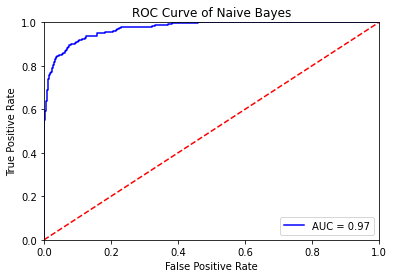

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Naive Bayes')
plt.show()

For the data being imbalanced, I'm using SMOTETomek, combination of oversampling the minority class with SMOTE and undersamling the majority class with Tomek Links. 

In [ ]:
from imblearn.combine import SMOTETomek 

smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1)

### Building the model

In [ ]:
#importing the classifier modules

from sklearn.ensemble import RandomForestClassifier 

In [ ]:
#Building the random forest classifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

start = time()

rf.fit(X_train, y_train)

print("RandomForestClassifier took %.2f seconds"
      % (time() - start,))

print(f"Accuracy: {round(rf.score(X_test, y_test)*100)}%")

print("Parameters: ", rf.get_params())

RandomForestClassifier took 34.88 seconds
Accuracy: 100%
Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
#displaying the confusion matrix and classifier scores for the model
y_predicted = rf.predict(X_test)
confusion_matrix(y_test, y_predicted)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5171
           1       1.00      0.99      1.00      5038

    accuracy                           1.00     10209
   macro avg       1.00      1.00      1.00     10209
weighted avg       1.00      1.00      1.00     10209



0 Classifier: ROC AUC=0.500
RFC Classifier: ROC AUC=1.000


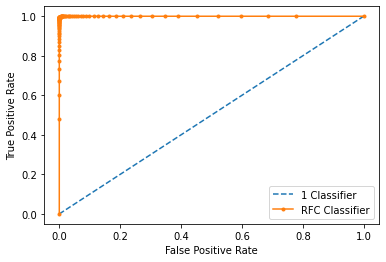

In [ ]:
#plot the ROC curve and calculate the AUC
#create a classifier that always picks 0 choice (to compare result to the classifier model)
ns_probs = [0 for _ in range(len(y_test))]
rf_probs = rf.predict_proba(X_test)

# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

#calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

#summarize scores
print('0 Classifier: ROC AUC=%.3f' % (ns_auc))
print('RFC Classifier: ROC AUC=%.3f' % (rf_auc))

#calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

#plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='1 Classifier')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RFC Classifier')

#axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Conclusion


Due to the data being highly imbalanced, the models tend to overfit the data. This is a major issue when dealing with class imbalance. That being said, models built with Passive Aggressive and KNN classifier gave exceptional results on the test dataset. Moreover, using SmoteTomek and retraining the Random Forest Classifier, gave us the recall of 0.99 and precision of 1.0.
The best model therefore, is the Random Forest Classifier.

# Future Work

Down the line, I would like to work on making this project from being machine learning based to deep learning based.I would like to further work on the imbalance of data. I would like to work on training models like XGBoost and the Decision Tree Classifier. Also, instead of using TF-IDF for preprocessing, I would like to explore word embedding techniques with tools like Word2Vec.
